# **Modelos de Inteligencia Artificial para Series Temporales**

## Probabilistic forecasting I: Temperature

- Anny Álvarez Nogales
- Paula Arias Fernández

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import aeon
#pip install utility_script_crps_score
#pip install statsmodels
#pip install aeon
#pip install lightgbm

# EDA

## Gráficas y Análisis de datos
Analizamos por una parte los datos de temperatura de train y valores que se van a predecir en test.

In [115]:
train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64320 entries, 0 to 64319
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         64320 non-null  datetime64[ns]
 1   feature_AA   64320 non-null  float64       
 2   feature_AB   64320 non-null  float64       
 3   feature_BA   64320 non-null  float64       
 4   feature_BB   64320 non-null  float64       
 5   feature_CA   64320 non-null  float64       
 6   feature_CB   64320 non-null  float64       
 7   Temperature  64320 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 4.4 MB


In [118]:
train_df.head()

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,,,,,,,,
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


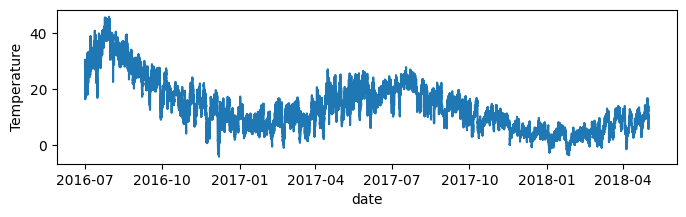

In [ ]:
fig, ax = plt.subplots(1,  1, figsize=(8, 2))
_ = sns.lineplot(train_df, x='date', y='Temperature', ax=ax)

Analizamos la forma de las demás características que aparecen en el dataframe, ya que por la descripción del reto, no se define que refleja cada una:

- Feature_AA:esta variable presenta una alta variabilidad y una tendencia general creciente a lo largo del tiempo.
- Feature_AB muestra una forma más suavizada que feature_AA, con oscilaciones amplias pero menos abruptas.
- Feature_BA: Esta variable es notable por su fuerte ruido y presencia de valores extremos, tanto positivos como negativos
- Feature_BB: se comporta de forma más estable que Feature_BA, manteniéndose dentro de un rango estrecho con pequeñas oscilaciones
- Feature_CA: se reflejan segmentos con distinta varianza.
- Feature_CB: esta variable muestra saltos marcados y tramos claramente diferenciado

La temperatura presenta un patrón suave, con una ligera tendencia decreciente a lo largo del tiempo. 
Sin embargo es necesario acotar el rango de fechas para analizar la señal

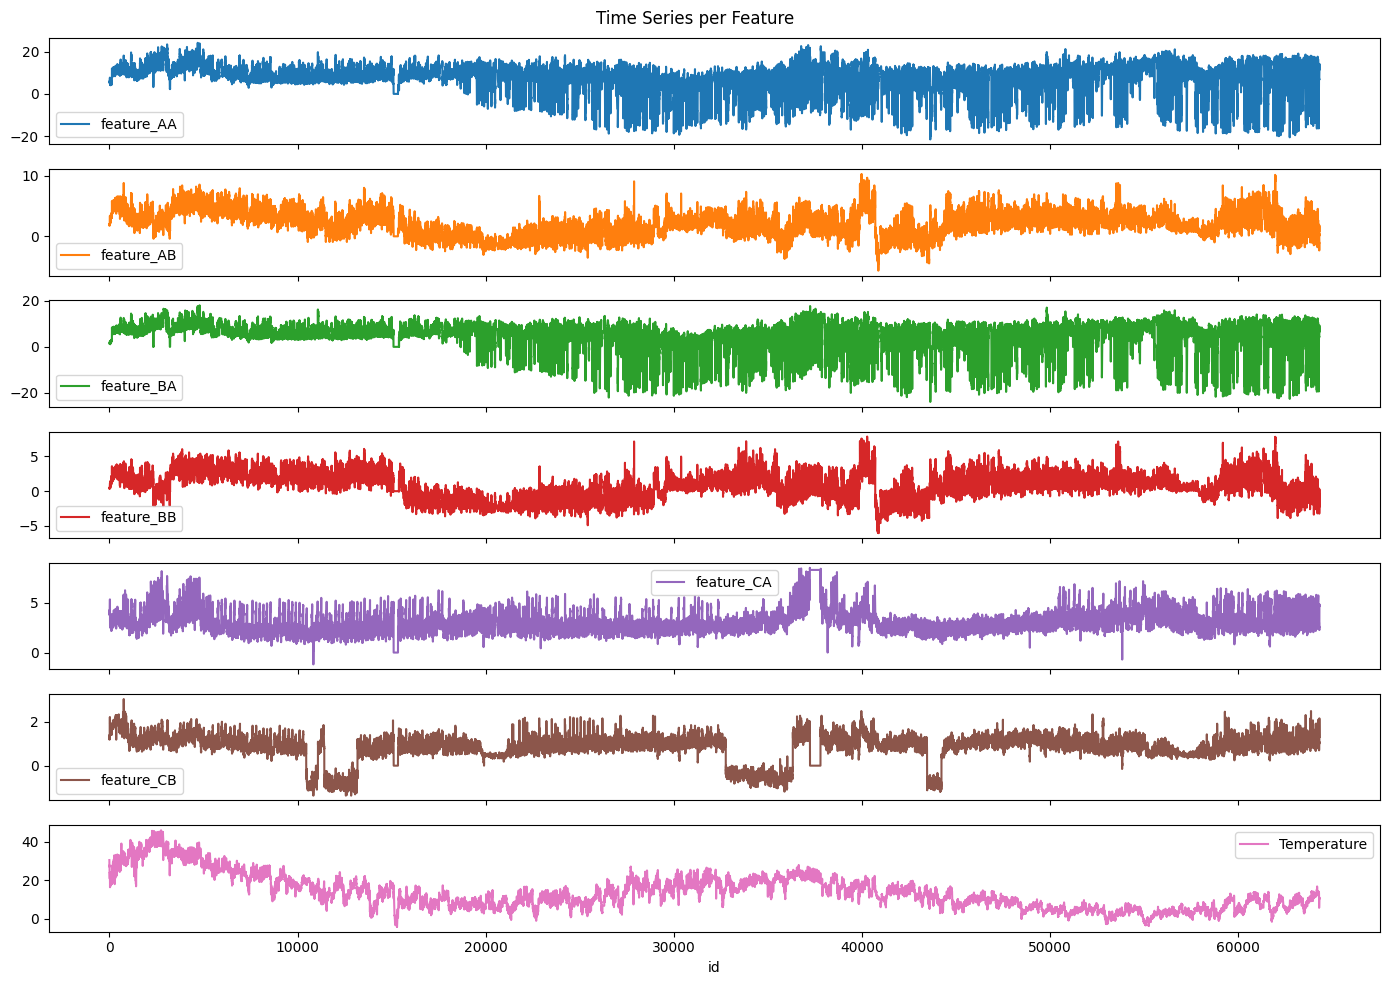

In [ ]:
#visualizar características de train

features = [col for col in train_df.columns if col not in ['id','date']]
train_df[features].plot(subplots=True, figsize=(14, 10), title="Time Series per Feature")
plt.tight_layout()
plt.show()


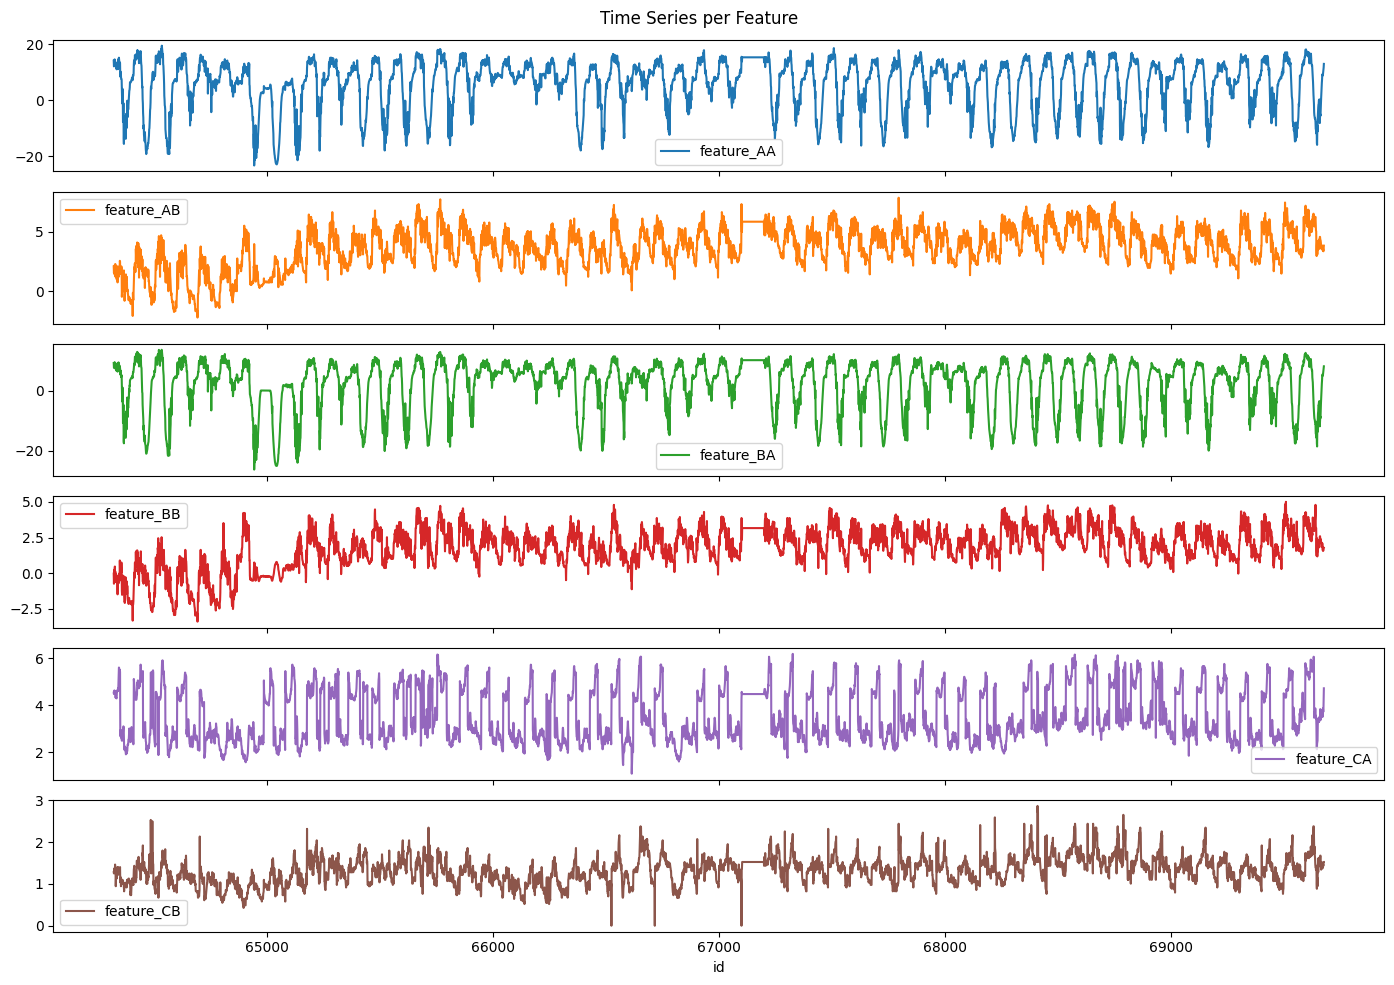

In [ ]:
#visualizar características de test
features = [col for col in test_df.columns if col not in ['id','date']]
test_df[features].plot(subplots=True, figsize=(14, 10), title="Time Series per Feature")
plt.tight_layout()
plt.show()

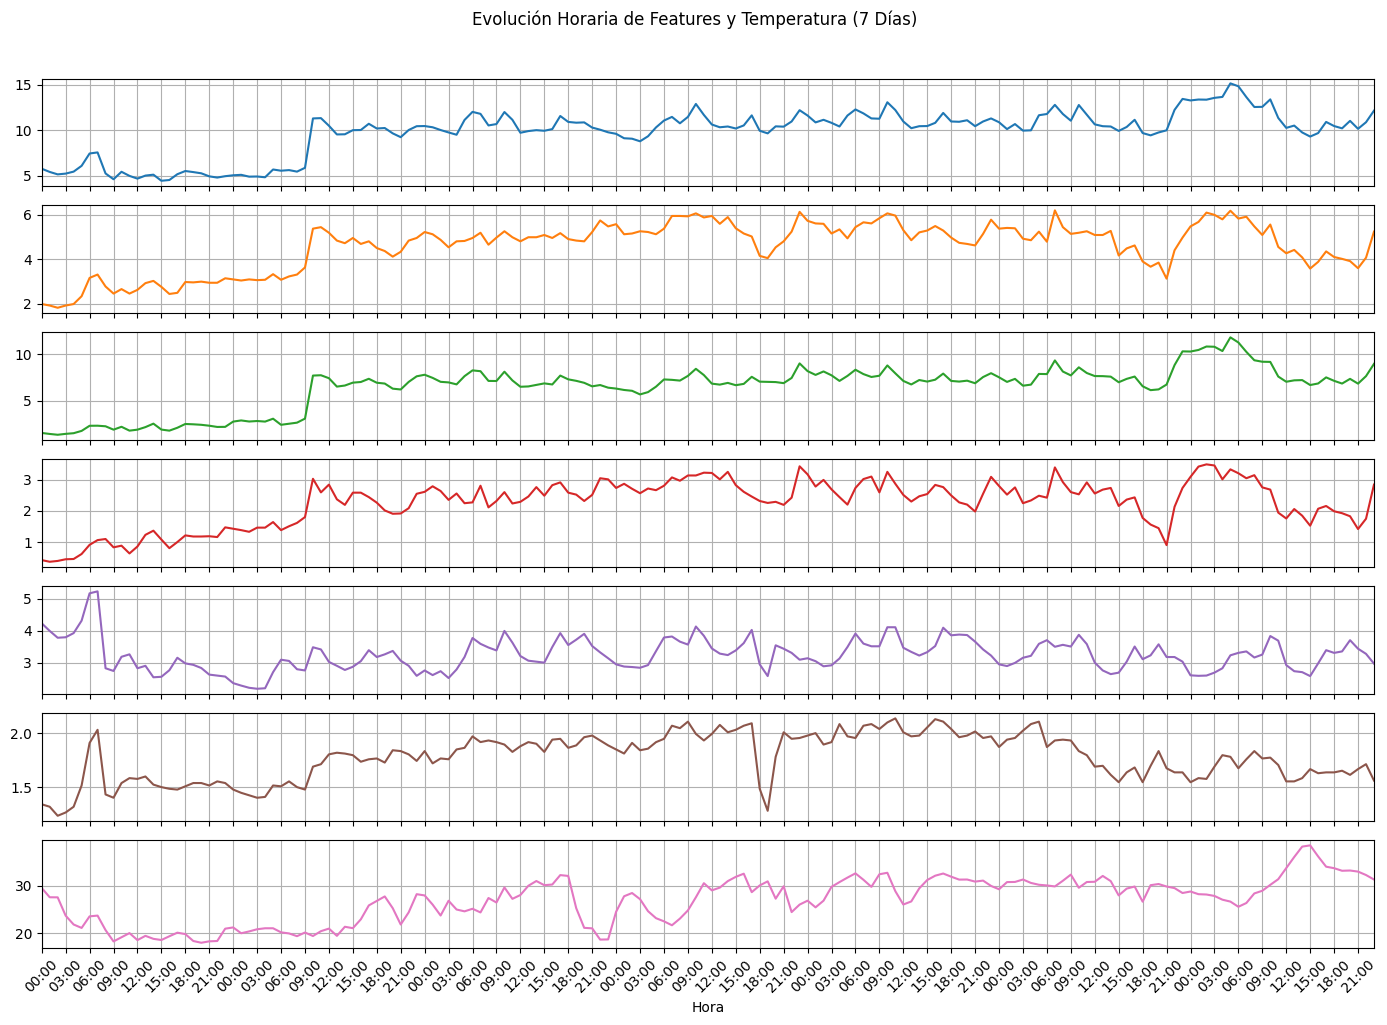

In [ ]:
#seleccionar dias de la visualización

dias= 7


train_df['date'] = pd.to_datetime(train_df['date'])

start_date = train_df['date'].min()
end_date = start_date + pd.Timedelta(days=dias)
df_2days = train_df[(train_df['date'] >= start_date) & (train_df['date'] < end_date)]

# garficar por hora
df_2days_hourly = df_2days.set_index('date').resample('1H').mean()

features = [col for col in df_2days_hourly.columns if col != 'Temperature']

# subplots con eje x en horas
fig, axes = plt.subplots(len(features)+1, 1, figsize=(14, 10), sharex=True)
df_2days_hourly[features + ['Temperature']].plot(subplots=True, ax=axes, legend=False)

axes[-1].set_xlabel("Hora")
for ax in axes:
    ax.grid()
    ax.set_xlim(df_2days_hourly.index.min(), df_2days_hourly.index.max())
    ax.set_xticks(pd.date_range(df_2days_hourly.index.min(), df_2days_hourly.index.max(), freq='3H'))
    ax.set_xticklabels([d.strftime('%H:%M') for d in pd.date_range(df_2days_hourly.index.min(), df_2days_hourly.index.max(), freq='3H')], rotation=45)

plt.suptitle(f"Evolución Horaria de Features y Temperatura ({dias} Días)", y=1.02)
plt.tight_layout()
plt.show()


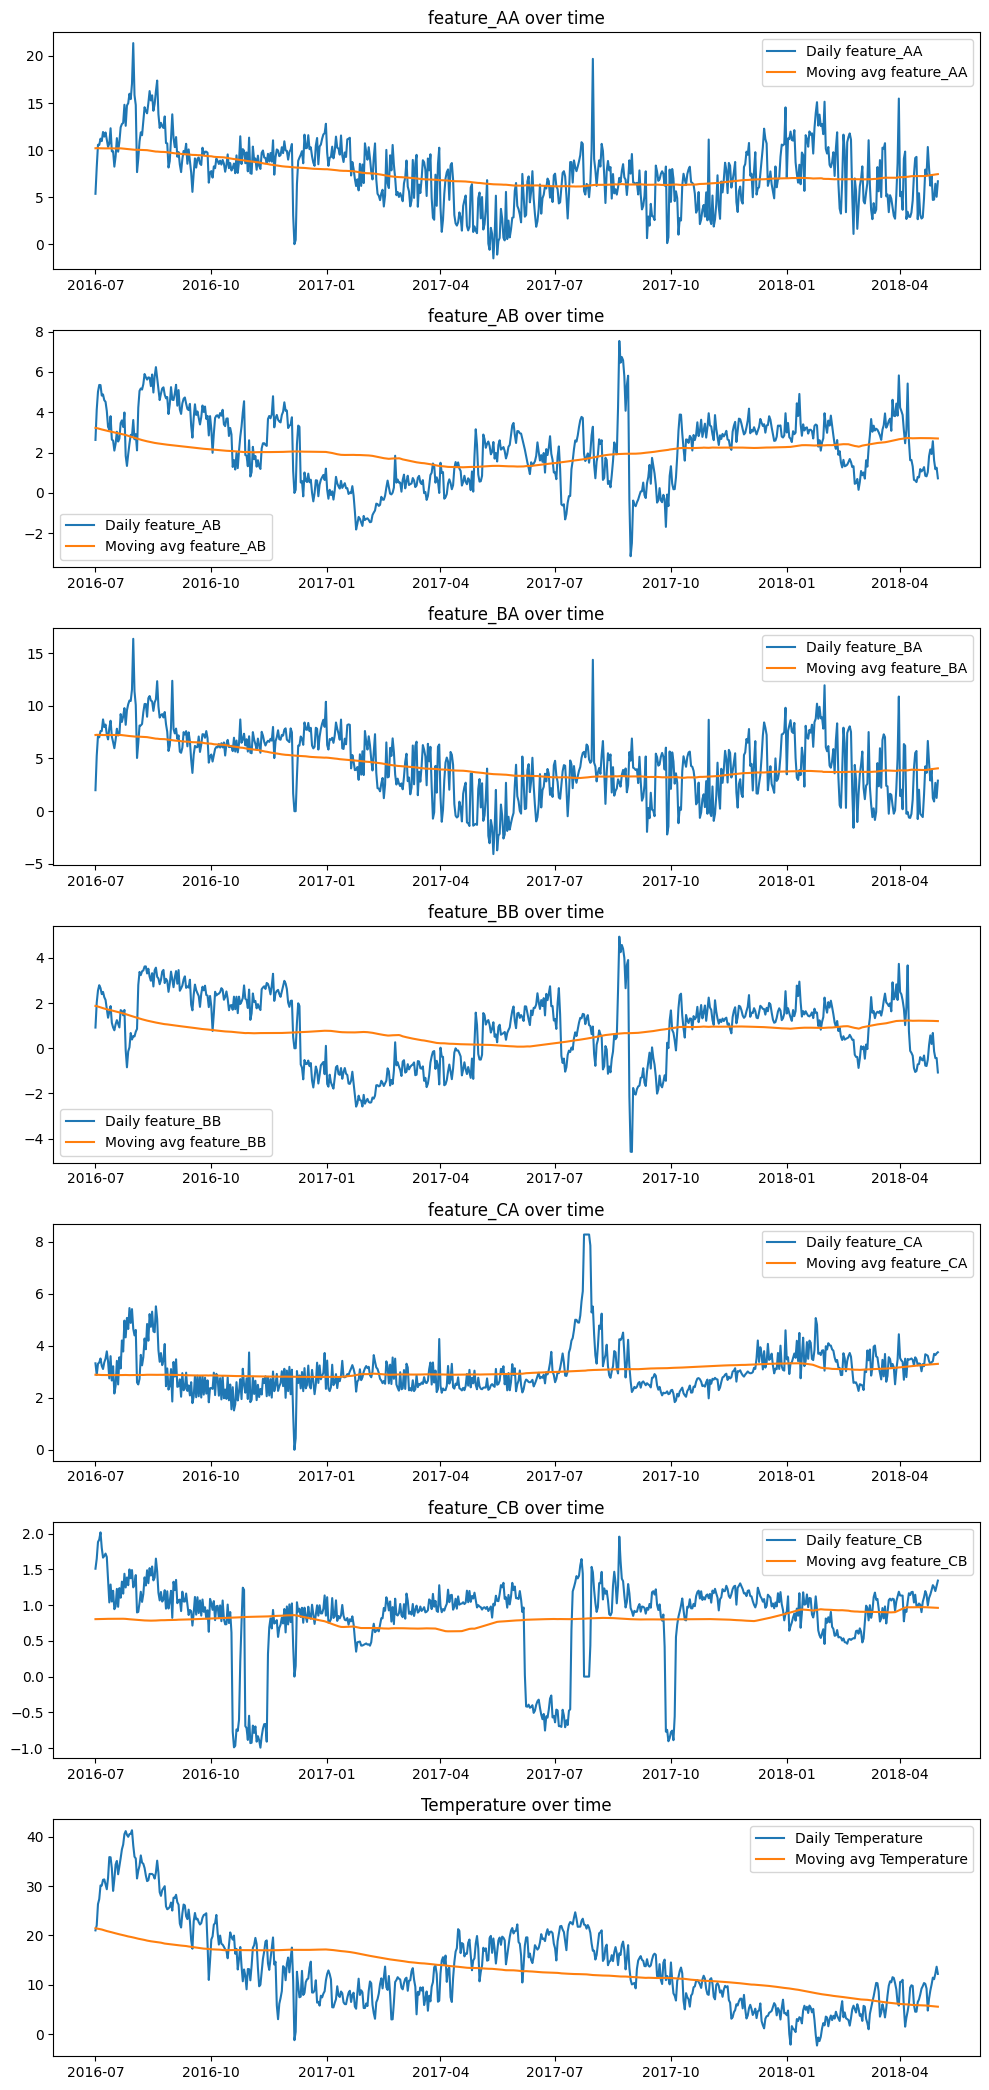

In [ ]:
# datos diarios
daily_data = (
    train_df[['date', 'feature_AA', 'feature_AB', 'feature_BA', 'feature_BB', 'feature_CA', 'feature_CB', 'Temperature']]
    .set_index('date')
    .resample('D')
    .mean() 
    .reset_index()
)
# usar ventana 
moving_average = daily_data.set_index('date').rolling(
    window=365,       
    center=True,      
    min_periods=183,
).mean().reset_index()   


fig, ax = plt.subplots(len(daily_data.columns) - 1, 1, figsize=(10, 3 * (len(daily_data.columns) - 1)))

# Graficar cada característica
for i, column in enumerate(daily_data.columns[1:]):  # Excluye la columna 'date' al graficar
    ax[i].plot(daily_data['date'], daily_data[column], label=f'Daily {column}')
    ax[i].plot(moving_average['date'], moving_average[column], label=f'Moving avg {column}')
    ax[i].set_title(f'{column} over time')
    ax[i].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
#  Prueba de Dickey-Fuller aumentada (ADF) sobre la serie temporal para determinar si es estacionaria o no estacionaria.
#hay que tener en cuenta que puede ser estacionaria o no en un rango de tiempo
# y no en otro.

from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(train_df['Temperature'])


ADF Test Statistic : -4.040257538726736
p-value : 0.0012137779642669056
#Lags Used : 61
Number of Observations : 64258
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [138]:
from statsmodels.tsa.stattools import adfuller

for col in features:
    result = adfuller(train_df[col].dropna())
    print(f"{col}: p-value = {result[1]:.4f} {'✅ Stationary' if result[1] < 0.05 else '❌ Not stationary'}")


feature_AA: p-value = 0.0000 ✅ Stationary
feature_AB: p-value = 0.0000 ✅ Stationary
feature_BA: p-value = 0.0000 ✅ Stationary
feature_BB: p-value = 0.0000 ✅ Stationary
feature_CA: p-value = 0.0000 ✅ Stationary
feature_CB: p-value = 0.0000 ✅ Stationary


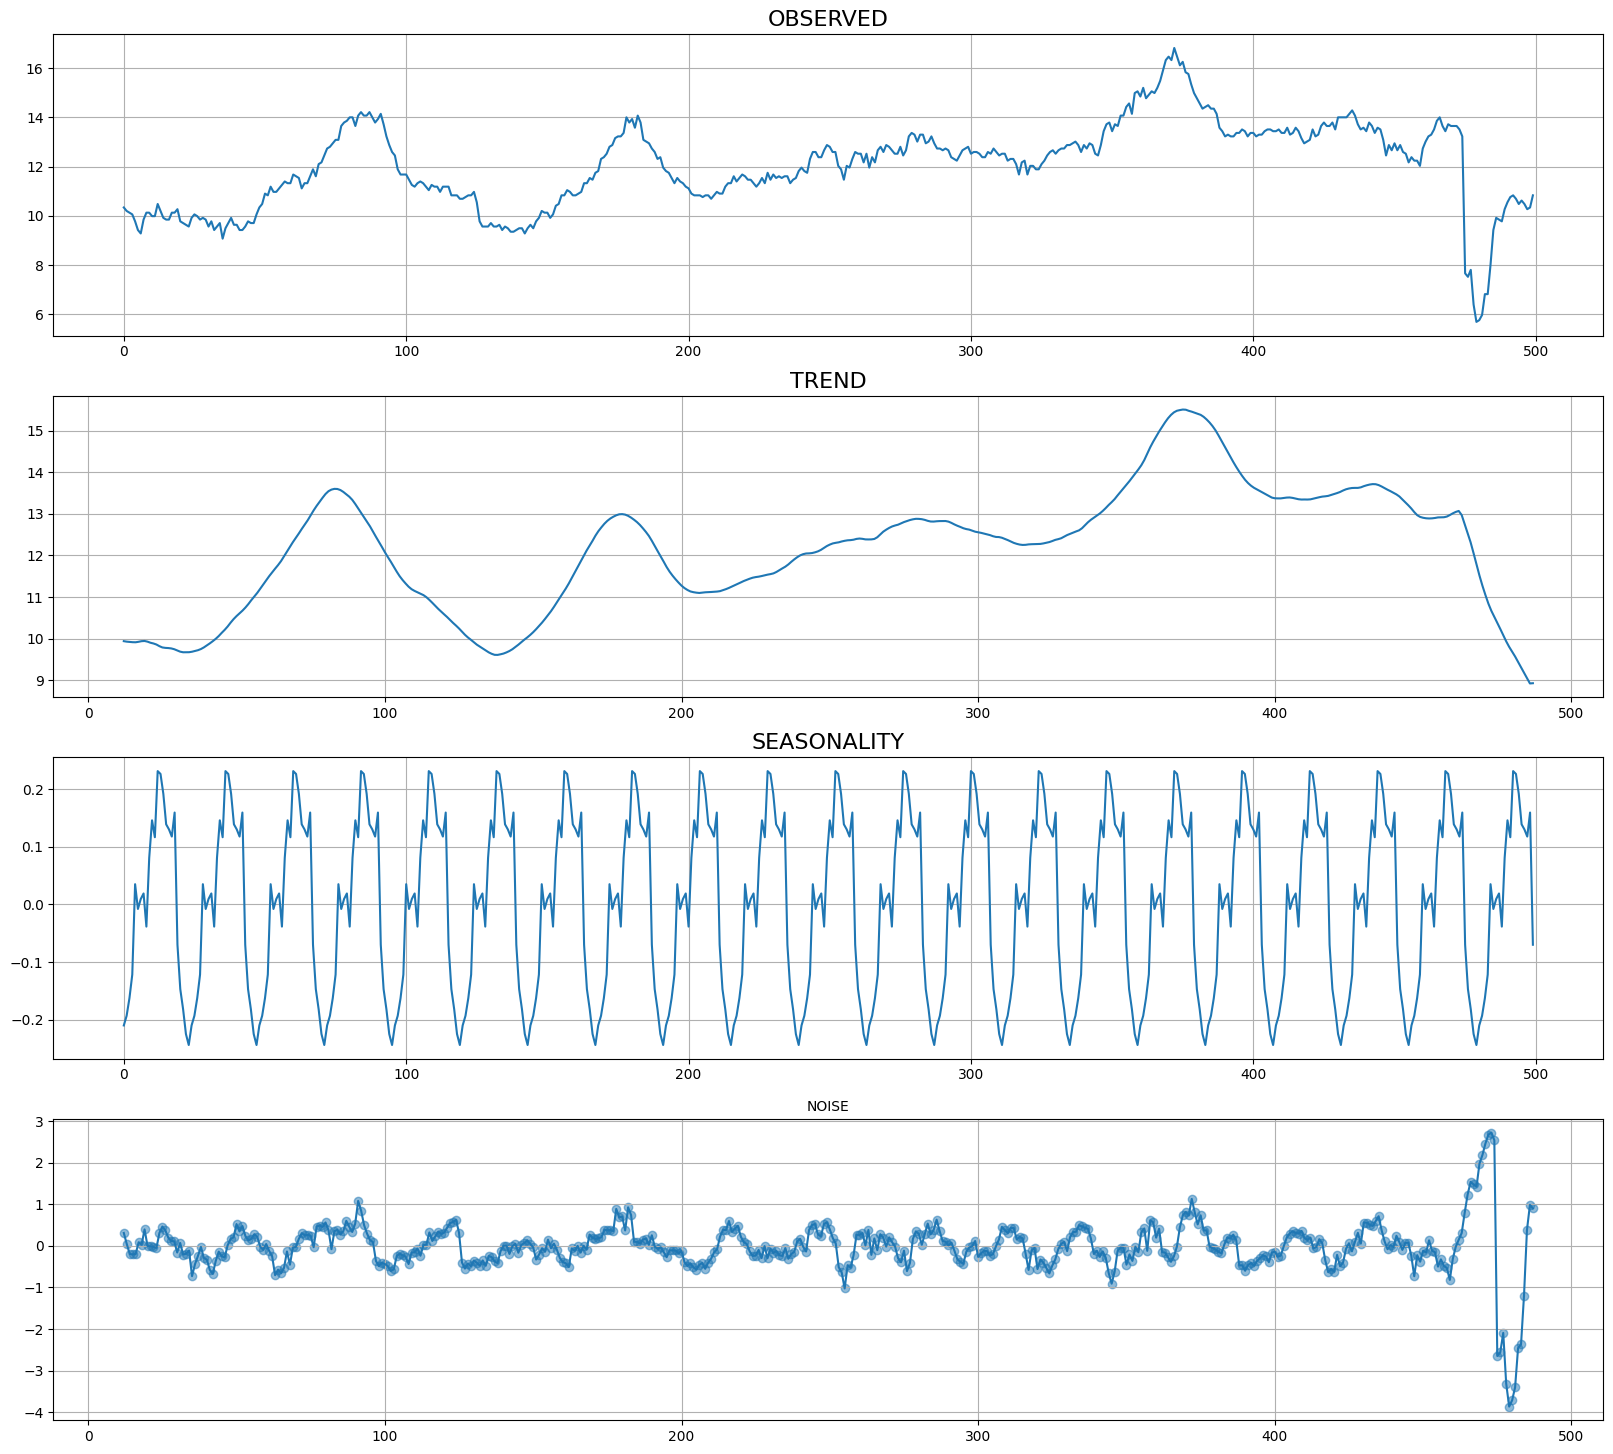

In [ ]:
# Análisis de estacionalidad, tendencia y ruido 

from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_analysis(train_df, share_type='xyz', samples=500, period=24):
    if samples == 'all':
        res = seasonal_decompose(train_df[share_type].values, period=period)
    else:
        res = seasonal_decompose(train_df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    fig, axs = plt.subplots(4, figsize=(20,18))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    axs[3].set_title('NOISE', fontsize=10)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

seasonal_analysis(train_df, share_type='Temperature', samples=500, period=24)

Missing values:
 date           0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
dtype: int64


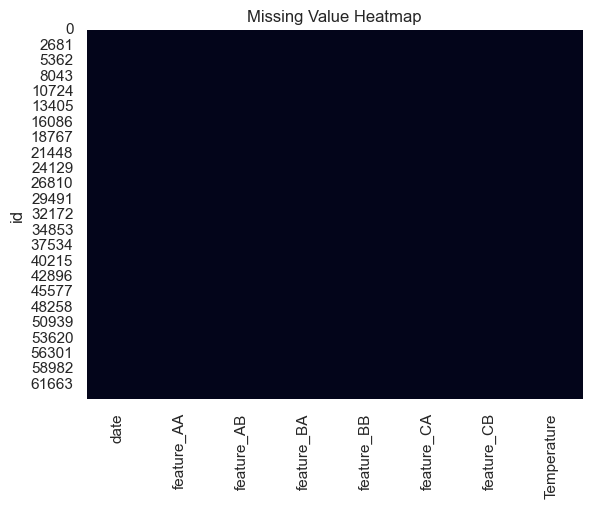

In [ ]:
# Buscar valores nulos para que, en caso de haberlos buscar estrategias como usar
#interpolación, la media, ventana deslizante, etc.
print("Missing values:\n", train_df.isnull().sum())

# Optional: visualize missingness
sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()


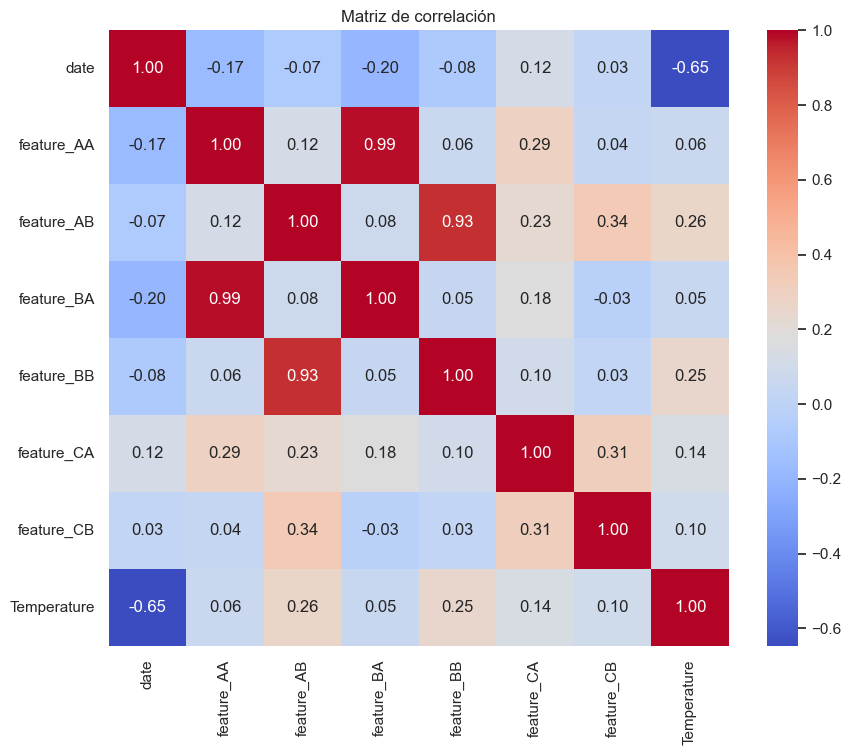

In [ ]:
# Ver la correlación de los datos, de las features entre sí y con la Temperatura
corr_matrix = train_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


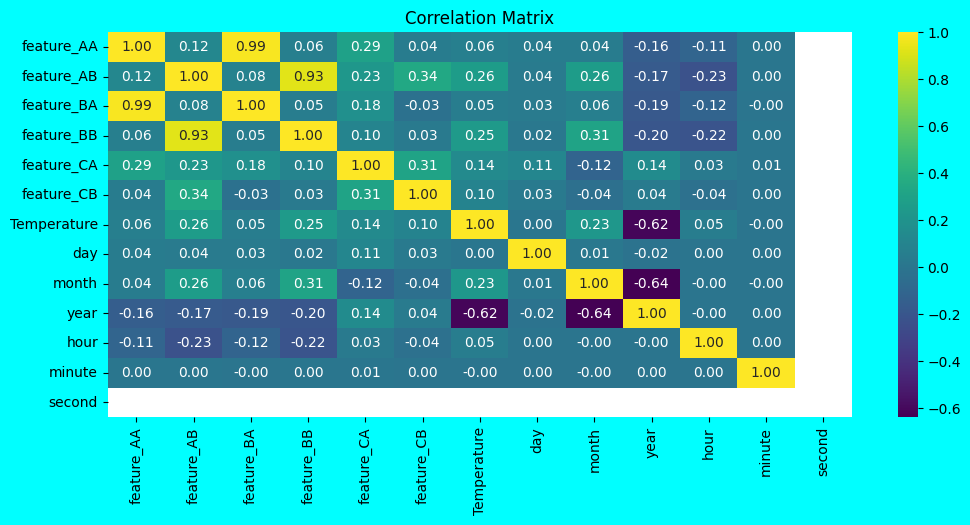

In [ ]:
# Correlación más detallada entre las variables con las fechas más extendidas

train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['hour'] = train_df['date'].dt.hour
train_df['minute'] = train_df['date'].dt.minute
train_df['second'] = train_df['date'].dt.second
train_df.drop(columns=['date'], inplace=True)  
corr_matrix = train_df.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.gcf().set_facecolor('#00FFFF')  
plt.title('Correlation Matrix')
plt.show()

# Modelos

Se presentan los modelos utilizados, como no tenemos las etiquetas verdaderas de test, el enfoque utilizado ha sido trabajar con los datos de train y dividirlos en datos de entrenamiento y validacion
Con esos datos de validacion podiamos hacer predicciones probabilisticas y evaluar el quantil 0.5 con la etiqueta real
En cuanto a los datos de test, al no tener la temperatura, hemos graficado los valores para ver si tenian coherencia

Los modelos y enfoques han sido:
- Promedio Móvil Simple (SMA): calcula el promedio de las últimas 24 mediciones de temperatura para predecir la siguiente (fue una primera prueba para tener un punto de referencia, no captura tendencias o patrones complejos, y no da predicciones probabilísticas)

- Forecast Probabilístico con Distribución Normal:  este asume que los últimos valores de la temperatura siguen una distribución normal (como una campana). Calcula el promedio y la desviación estándar de los últimos valores y usa esta información para estimar los cuantiles. Aunque permite generar predicciones probabilísticas, el modelo asume que los datos siguen una distribución normal, lo cual no siempre es cierto. Fue probado con los datos de entrenamiento y luego usado para hacer predicciones en el conjunto de test.

- Random Forest Regressor (con cuantiles de árboles)
Este modelo es más complejo y se basa en un conjunto de árboles de decisión. Se entrena con una ventana de 48 horas de datos y, para cada predicción, toma en cuenta los resultados de todos los árboles para calcular los cuantiles de la predicción.

- Naive Forecaster (con y sin Bootstrap usando aeon): Este es un modelo sencillo que predice el próximo valor usando el último valor observado o el promedio. Si se usa el método bootstrap, genera múltiples predicciones posibles para estimar la incertidumbre

-  LightGBM : junto con la técnica de bootstrapping para estimar la incertidumbre de las predicciones.

## Promedio Móvil Simple

Tutorial seguido: https://github.com/vrodriguezf/sertemp/tree/main/nbs/forecasting

Test RMSE: 0.919


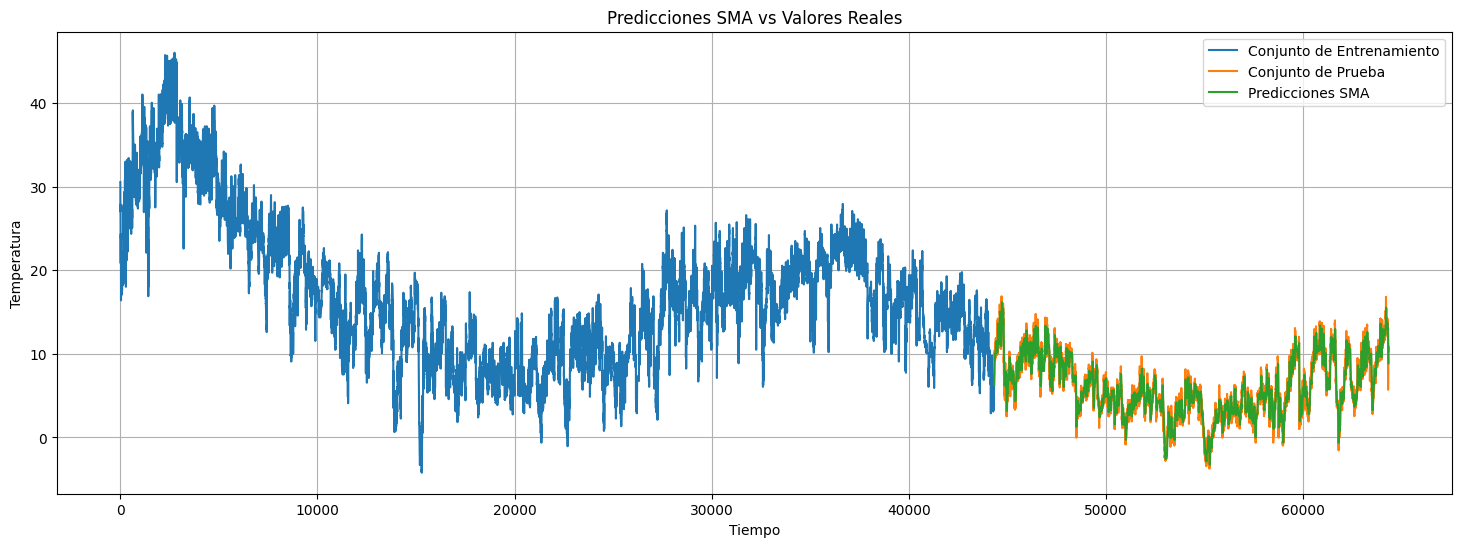

In [ ]:
# PRIMERA PRUEBA 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])
test_df

# Función para graficar y validar
def plot_and_validate(train, test, predictions):
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"Test RMSE: {rmse:.3f}")
    
    plt.figure(figsize=(18,6))
    
    # Graficar entrenamiento
    plt.plot(train.index, train, label='Conjunto de Entrenamiento')

    # Graficar test y predicciones
    plt.plot(test.index, test, label='Conjunto de Prueba')
    plt.plot(test.index, predictions, label='Predicciones SMA')

    plt.xlabel('Tiempo')
    plt.ylabel('Temperatura')
    plt.title('Predicciones SMA vs Valores Reales')
    plt.legend()
    plt.grid()
    plt.show()

# Modelo de Promedio Móvil Simple
def model_sma(history, window_size):
    return np.mean(history[-window_size:])

# Inicializar la lista de predicciones SMA
predictions_sma = []
history = train_df['Temperature'].tolist()

# Realizar predicción paso a paso (walk-forward validation)
for i in range(len(test_df)):
    yhat = model_sma(history, window_size=24)  # Ventana de 24 pasos
    predictions_sma.append(yhat)
    history.append(yhat)  # En este caso, no usamos el valor real porque estamos simulando forecast
train_df = train_df.sort_values('date').reset_index()
train_df['time_idx'] = np.arange(len(train_df))
# Dividir el conjunto de entrenamiento en entrenamiento real y validación (utilizaremos
# el último 20% de los datos para la validación)

cutoff = train_df['id'].max() - 20000 
train_cut = train_df[train_df['time_idx'] <= cutoff]
eval_cut = train_df[train_df['time_idx'] > cutoff]

# Preparar la lista de valores para SMA
history = train_cut['Temperature'].tolist()
predictions_sma = []

# Hacer predicciones sobre el conjunto de validación
for i in range(len(eval_cut)):
    yhat = model_sma(history, window_size=24)
    predictions_sma.append(yhat)
    history.append(eval_cut['Temperature'].iloc[i])  # Aquí sí añadimos el valor real

# Evaluar y graficar
plot_and_validate(train_cut['Temperature'], eval_cut['Temperature'], predictions_sma)


Lo adaptamos a nuestra tarea

Test RMSE (cuantil 0.5): 0.919


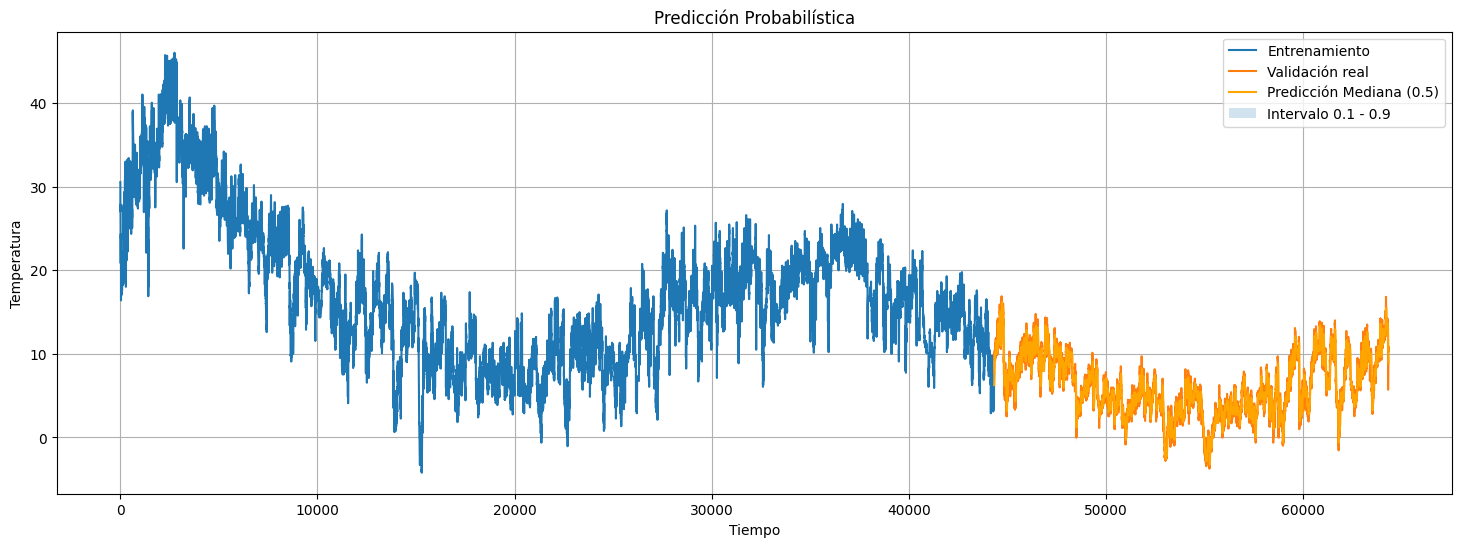

In [ ]:
# DATOS DE EVALUACIÓN
from scipy.stats import norm

quantiles = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
             0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]

def plot_and_validate(train, test, quantile_predictions):
    rmse = np.sqrt(mean_squared_error(test, quantile_predictions[0.5]))
    print(f"Test RMSE (cuantil 0.5): {rmse:.3f}")

    plt.figure(figsize=(18,6))
    plt.plot(train.index, train, label='Entrenamiento')
    plt.plot(test.index, test, label='Validación real')
    plt.plot(test.index, quantile_predictions[0.5], label='Predicción Mediana (0.5)', color='orange')
    plt.fill_between(test.index,
                     quantile_predictions[0.1],
                     quantile_predictions[0.9],
                     alpha=0.2, label='Intervalo 0.1 - 0.9')
    plt.xlabel('Tiempo')
    plt.ylabel('Temperatura')
    plt.title('Predicción Probabilística')
    plt.legend()
    plt.grid()
    plt.show()

# Forecast probabilístico
def forecast_probabilistic(history, window_size, quantiles):
    window = history[-window_size:]
    mean = np.mean(window)
    std = np.std(window)
    if std == 0:
        std = 1e-6  # evitar valores nulos

    return {q: norm.ppf(q, loc=mean, scale=std) for q in quantiles}

# entrenamos
window_size = 24
train_df = train_df.sort_values('date').reset_index(drop=True)
train_df['time_idx'] = np.arange(len(train_df))

# usamos el 20% para validar
cutoff = train_df['time_idx'].max() - 20000
train_cut = train_df[train_df['time_idx'] <= cutoff]
eval_cut = train_df[train_df['time_idx'] > cutoff]

history = train_cut['Temperature'].tolist()
quantile_predictions = {q: [] for q in quantiles}

# predecimos
for i in range(len(eval_cut)):
    pred = forecast_probabilistic(history, window_size, quantiles)
    for q in quantiles:
        quantile_predictions[q].append(pred[q])
    history.append(eval_cut['Temperature'].iloc[i])

plot_and_validate(train_cut['Temperature'], eval_cut['Temperature'], quantile_predictions)



In [ ]:
# DATOS DE TEST
# predecimos y graficamos ahora para los datos de test 

history = train_df['Temperature'].tolist()
quantile_predictions_test = {q: [] for q in quantiles}

for _ in range(len(test_df)):
    pred = forecast_probabilistic(history, window_size, quantiles)
    for q in quantiles:
        quantile_predictions_test[q].append(pred[q])
    history.append(pred[0.5])

test_df.reset_index(inplace=True)
predictions_test = pd.DataFrame({'id': test_df['id']})
for q in quantiles:
    predictions_test[str(q)] = quantile_predictions_test[q]

predictions_test

,id,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
1,64321,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
2,64322,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
3,64323,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
4,64324,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
5356,69676,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
5357,69677,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735
5358,69678,5.403431,5.981437,6.64784,7.097459,7.454802,7.76137,8.036678,8.291792,8.53387,...,9.229083,9.463297,9.705375,9.960488,10.235796,10.542365,10.899708,11.349327,12.01573,12.593735


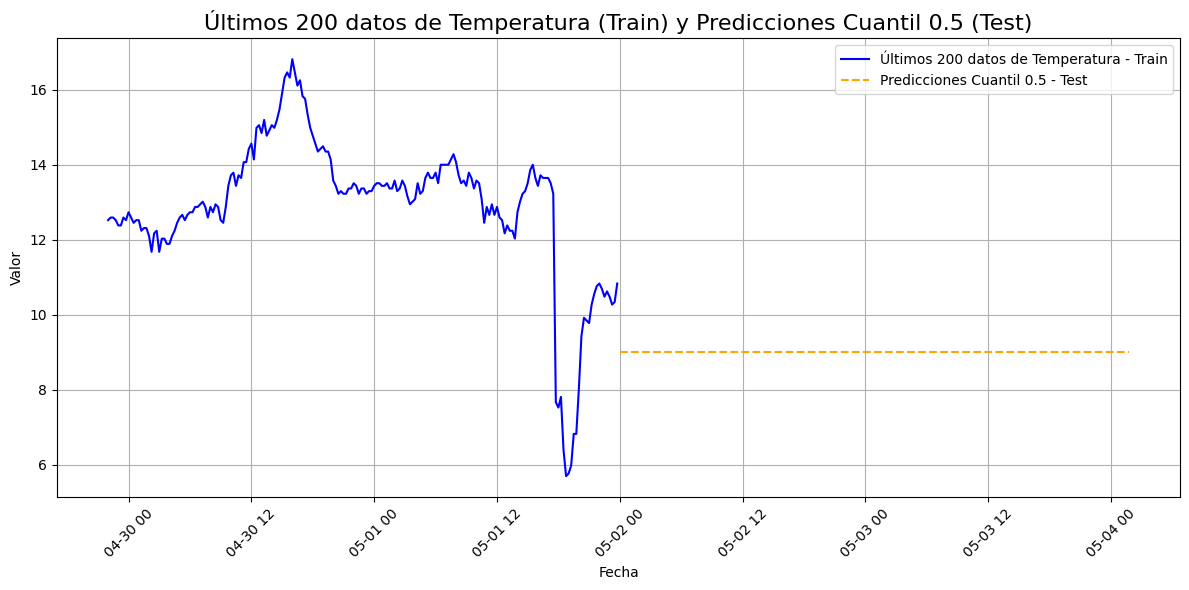

In [179]:
import matplotlib.pyplot as plt

last_train_date = train_df['date'].max()
first_test_date = test_df['date'].min()

import matplotlib.pyplot as plt

last_200_train_temp = train_df[['date', 'Temperature']].tail(200)
quantile_50_test = predictions_test['0.5'].head(200)  

# Graficar los últimos 200 datos de train_df junto con los primeros 200 datos de test_df
plt.figure(figsize=(12, 6))
plt.plot(last_200_train_temp['date'], last_200_train_temp['Temperature'], label='Últimos 200 datos de Temperatura - Train', color='blue')
plt.plot(test_df['date'].head(200), quantile_50_test, label='Predicciones Cuantil 0.5 - Test', color='orange', linestyle='--')

plt.title('Últimos 200 datos de Temperatura (Train) y Predicciones Cuantil 0.5 (Test)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Random Forest

In [147]:
from sklearn.ensemble import RandomForestRegressor
train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])
test_df

train_X = train_df[[feature for feature in train_df.columns if feature.startswith("feature")]]
train_y = train_df["Temperature"]

test_X = test_df[[feature for feature in test_df.columns if feature.startswith("feature")]]
test_X

model = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [153]:
train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])
train_df = train_df.sort_values('date').reset_index(drop=True)
train_df['time_idx'] = np.arange(len(train_df))

In [154]:
# Cuantiles
quantiles = [0.025,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975]

# Dividir el conjunto de datos en entrenamiento y evaluación
train_cutoff = train_df['time_idx'].max() - 20000  
train_data = train_df[train_df['time_idx'] <= train_cutoff]
eval_data = train_df[train_df['time_idx'] > train_cutoff]

train_X = train_data[[feature for feature in train_data.columns if feature.startswith("feature")]]
train_y = train_data["Temperature"]

eval_X = eval_data[[feature for feature in eval_data.columns if feature.startswith("feature")]]
eval_y = eval_data["Temperature"]

# Entrenamos
model = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [227]:
# DATOS DE EVALUACIÓN
pred_y = [est.predict(eval_X.values) for est in model.estimators_]
proba_preds = np.array(pred_y)

quantile_predictions = {"index": eval_data.index.values}
quantile_predictions.update({q: None for q in quantiles})
for q in quantiles:
    quantile_predictions[q] = np.quantile(proba_preds, q, axis=0)
predictions_df = pd.DataFrame.from_dict(quantile_predictions)
predictions_df

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(eval_y, predictions_df[0.5]))
rmse

14.608204269819801

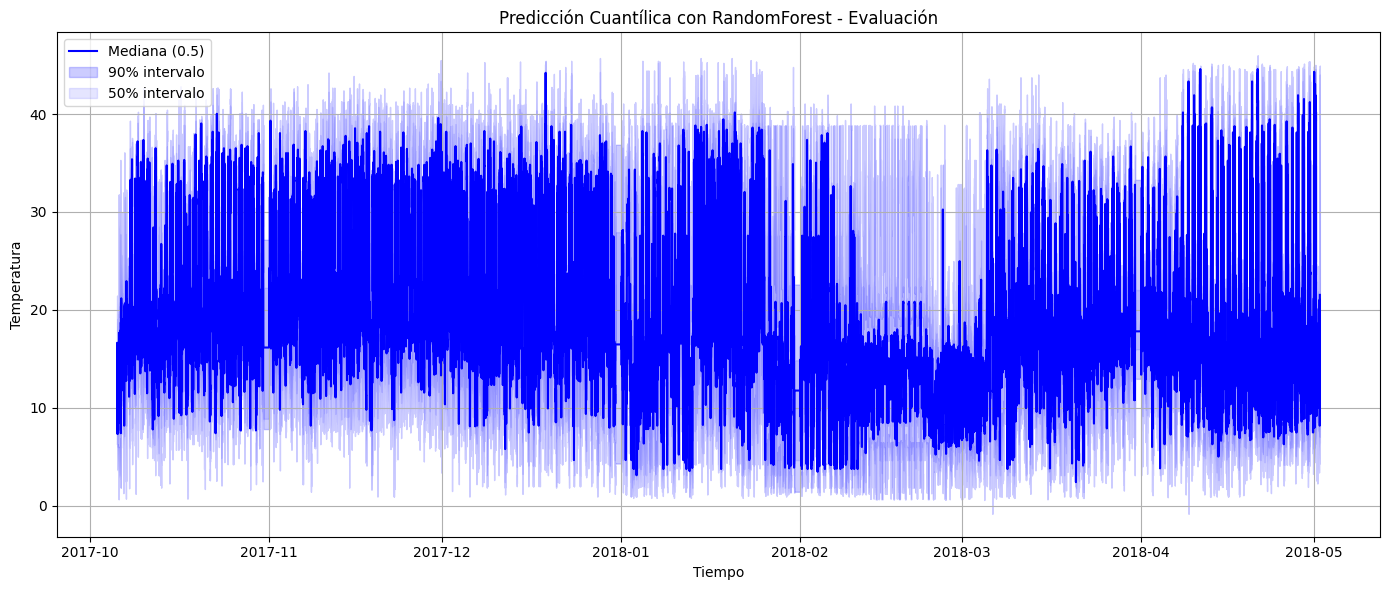

In [228]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

predictions_df["index"] = pd.to_datetime(predictions_df["index"])
predictions_df.set_index("index", inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(predictions_df.index, predictions_df[0.50], label="Mediana (0.5)", color="blue")

# Intervalo de confianza 90% (entre 0.05 y 0.95)
plt.fill_between(predictions_df.index,
                 predictions_df[0.05],
                 predictions_df[0.95],
                 color='blue', alpha=0.2, label="90% intervalo")

# Intervalo de confianza 50% (entre 0.25 y 0.75)
plt.fill_between(predictions_df.index,
                 predictions_df[0.25],
                 predictions_df[0.75],
                 color='blue', alpha=0.1, label="50% intervalo")

plt.title("Predicción Cuantílica con RandomForest - Evaluación")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [229]:
# DATOS DE TEST 
test_X = test_df[[feature for feature in test_df.columns if feature.startswith("feature")]]
test_X

pred_y = [est.predict(test_X.values) for est in model.estimators_]
proba_preds = np.array(pred_y)

quantile_predictions = {"index": test_df.index.values}
quantile_predictions.update({q: None for q in quantiles})
for q in quantiles:
    quantile_predictions[q] = np.quantile(proba_preds, q, axis=0)
predictions_test = pd.DataFrame.from_dict(quantile_predictions)
predictions_test


,index,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,2018-05-02 00:00:00,5.274250,5.27600,5.276,5.628000,6.261000,6.964000,8.231000,8.512000,9.4260,...,17.445999,17.445999,17.445999,17.445999,20.752001,20.823000,37.776001,39.042999,39.816002,39.887001
1,2018-05-02 00:15:00,4.432000,5.69800,6.613,6.964000,7.035000,7.386000,7.836700,7.949000,8.3710,...,8.934000,9.454400,9.989000,11.332900,13.296000,15.336000,17.375999,18.500999,21.525999,23.640499
2,2018-05-02 00:30:00,4.432000,4.43200,5.065,5.346000,6.331000,6.683000,7.316000,8.231000,8.5120,...,10.130000,10.200000,12.672900,14.280000,15.125000,16.320999,17.235001,21.026700,38.691002,38.691002
3,2018-05-02 00:45:00,4.291000,4.43200,6.050,7.738000,9.567000,12.100000,12.733000,14.773000,20.7806,...,35.174000,35.596001,36.580002,37.354000,37.776001,38.832001,38.832001,40.167999,42.630001,43.403999
4,2018-05-02 01:00:00,5.206000,5.62800,6.753,7.105000,7.668000,8.512000,8.512000,8.723000,9.4260,...,15.758000,15.758000,17.165001,17.165001,17.165001,17.221201,17.868000,38.269001,43.756001,44.952000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,2018-06-26 18:45:00,7.949000,8.51200,11.396,11.889000,13.085000,13.436000,14.140000,14.984000,15.0540,...,17.094000,17.460400,19.063999,20.330000,20.612000,21.385000,21.525999,22.089001,23.917999,30.601000
5356,2018-06-26 19:00:00,8.864000,8.86400,13.014,13.296000,15.758000,17.375999,18.923000,19.602150,20.8230,...,28.490999,30.108999,30.249001,30.671000,30.952999,31.023001,31.867001,33.203999,36.368999,39.535000
5357,2018-06-26 19:15:00,11.177975,13.29245,16.954,19.486000,19.697001,20.224750,21.245001,22.089001,24.2700,...,31.023001,31.233999,31.445000,32.219002,33.132999,34.470001,36.580002,37.354000,39.535000,40.167999
5358,2018-06-26 19:30:00,9.708000,11.18500,16.954,19.205000,19.275000,19.275000,19.275000,19.275000,19.4160,...,19.486000,19.486000,19.721850,19.908001,25.888000,29.052999,30.882000,31.726000,33.422051,35.106526


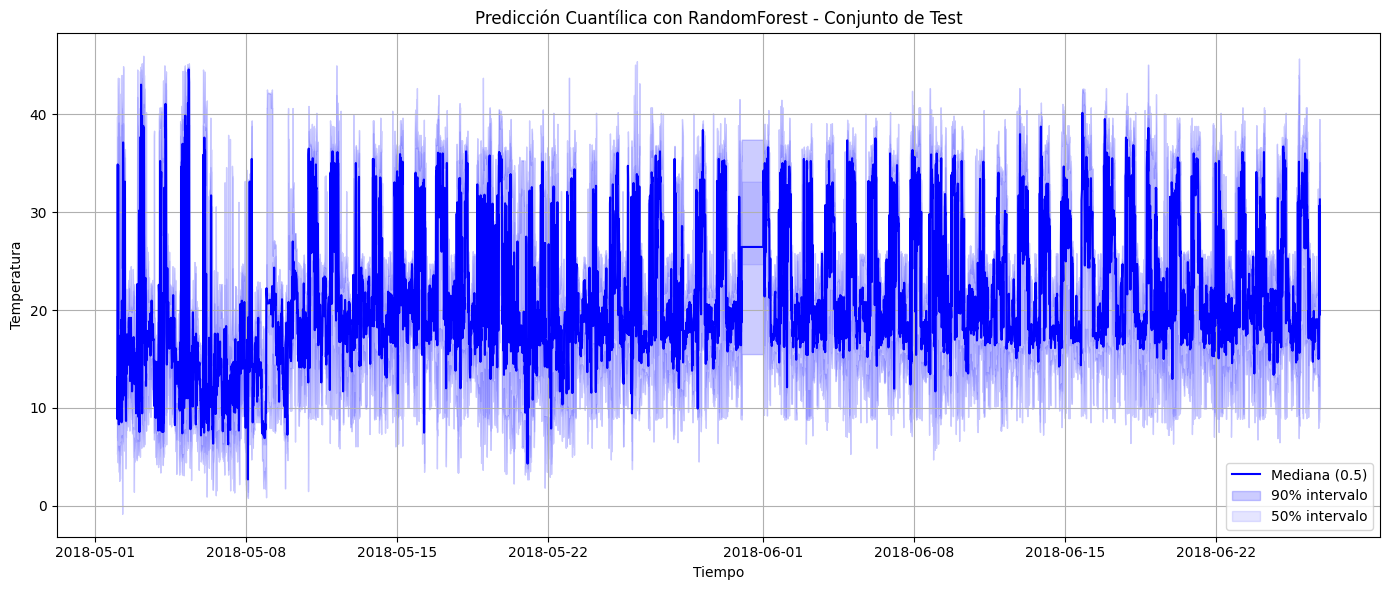

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

predictions_test["index"] = pd.to_datetime(predictions_test["index"])
predictions_test.set_index("index", inplace=True)

plt.figure(figsize=(14, 6))

# Graficar la mediana de las predicciones (cuantil 0.50)
plt.plot(predictions_test.index, predictions_test[0.50], label="Mediana (0.5)", color="blue")

# Intervalo de confianza 90% (entre 0.05 y 0.95)
plt.fill_between(predictions_test.index,
                 predictions_test[0.05],
                 predictions_test[0.95],
                 color='blue', alpha=0.2, label="90% intervalo")

# Intervalo de confianza 50% (entre 0.25 y 0.75)
plt.fill_between(predictions_test.index,
                 predictions_test[0.25],
                 predictions_test[0.75],
                 color='blue', alpha=0.1, label="50% intervalo")

plt.title("Predicción Cuantílica con RandomForest - Conjunto de Test")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


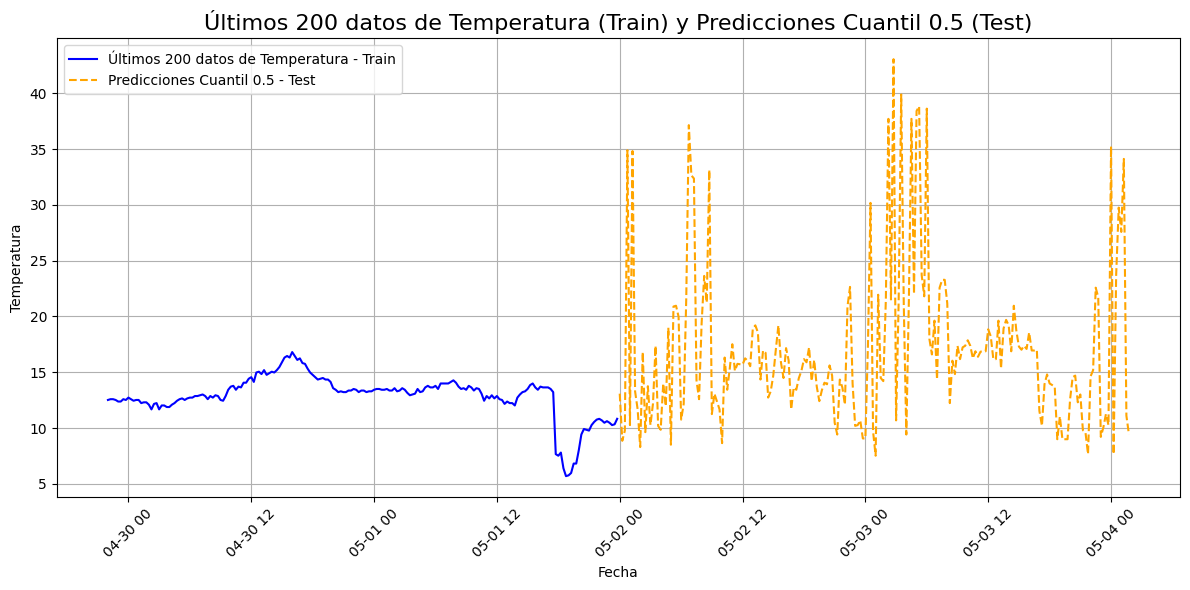

In [245]:
import matplotlib.pyplot as plt
train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)


last_200_train_temp = train_df[['date', 'Temperature']].tail(200)

quantile_50_test = predictions_test[0.50].head(200)
plt.figure(figsize=(12, 6))

# Graficar los últimos 200 valores de la temperatura de train
plt.plot(last_200_train_temp['date'], last_200_train_temp['Temperature'], label='Últimos 200 datos de Temperatura - Train', color='blue')
# Graficar las predicciones cuantil 0.5 de test
plt.plot(test_df['date'].head(200), quantile_50_test, label='Predicciones Cuantil 0.5 - Test', color='orange', linestyle='--')

plt.title('Últimos 200 datos de Temperatura (Train) y Predicciones Cuantil 0.5 (Test)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


## Naive forecast  (múltiples modelos NaiveForecaster con muestras bootstrap)




In [198]:
# DATOS DE TRAIN Y EVALUACIÓN
import numpy as np
import pandas as pd
from aeon.forecasting.naive import NaiveForecaster
from aeon.forecasting.base import ForecastingHorizon

# Cargar los datos
train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])

y = train_df['Temperature'].copy()
y.index = pd.to_datetime(train_df['date'])
y = y.asfreq('15T')  

fh = ForecastingHorizon(np.arange(1, len(test_df) + 1), is_relative=True)

cutoff = len(y) - 20000
train_data = y[:cutoff]
eval_data = y[cutoff:]

n_estimators = 100
boot_preds = []

# Aplicar bootstrap y predicciones
for i in range(n_estimators):
    idx = np.random.RandomState(i).choice(len(train_data), size=len(train_data), replace=True)
    y_boot_values = train_data.values[idx]
    
    y_boot = pd.Series(y_boot_values, index=train_data.index)
    
    forecaster = NaiveForecaster(strategy="last", sp=96, window_length=96)  # 'sp' = 96 para 24 horas en intervalos de 15 minutos
    forecaster.fit(y_boot)
    
    preds = forecaster.predict(fh)
    boot_preds.append(preds.values)

proba_preds = np.vstack(boot_preds)

quantiles = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]

quantile_predictions = {"index": test_df.index.values}
for q in quantiles:
    quantile_predictions[q] = np.quantile(proba_preds, q, axis=0)

predictions_eval= pd.DataFrame.from_dict(quantile_predictions)

predictions_eval

,index,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,5.617450,6.60245,7.3509,8.30100,9.1870,9.69050,11.4314,12.56750,13.3800,...,17.017000,17.474000,18.434850,19.486200,21.403251,24.072799,28.852649,31.473500,35.036549,39.900574
1,64321,4.940175,5.90550,8.0900,9.04335,10.0318,11.36100,12.4300,13.15500,14.2240,...,17.821949,18.656401,19.377200,20.865000,21.983250,22.834399,25.447800,30.804700,35.313999,37.166050
2,64322,5.687450,6.44735,8.0200,9.35220,10.3270,11.66025,12.4300,13.22500,14.9982,...,16.914950,18.796400,20.432200,21.258600,22.422750,24.860201,28.708751,31.184801,36.148151,39.575774
3,64323,2.511375,3.78845,5.4099,6.91135,8.1466,9.77850,10.5800,11.60700,12.7330,...,17.336950,17.924400,19.908001,20.654000,21.895751,23.735201,26.672501,32.789001,38.560549,40.822101
4,64324,5.311325,6.74600,7.8720,8.37100,10.1302,11.20275,12.5220,13.01400,14.1536,...,17.526850,18.656401,19.465000,20.400900,22.124250,23.369600,26.777950,30.115400,33.978001,34.517299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,5.362175,6.50330,8.4839,9.49700,10.4820,11.30850,12.2477,13.38700,13.9290,...,16.461000,17.136400,19.229500,20.548599,22.265000,23.397200,25.008450,27.927400,32.950501,36.479776
5356,69676,5.235225,6.04295,8.4839,9.34550,10.1300,10.79800,12.4444,13.99515,15.3356,...,18.673500,19.753600,20.917500,22.110001,22.810250,23.552200,25.757500,27.653700,33.720649,35.358276
5357,69677,4.410900,6.13120,8.6389,10.23555,12.0718,13.10225,13.4360,15.21600,15.5186,...,18.040501,18.656001,20.358350,20.865000,21.807750,22.792000,23.738651,28.546401,34.754549,35.146800
5358,69678,3.188700,4.19285,5.9796,7.40420,8.5398,9.35575,10.6717,12.04680,12.9722,...,15.750450,16.601999,17.970201,18.775300,20.787500,22.482601,24.505100,26.605400,32.676149,34.045926


Test RMSE (cuantil 0.5): 8.196


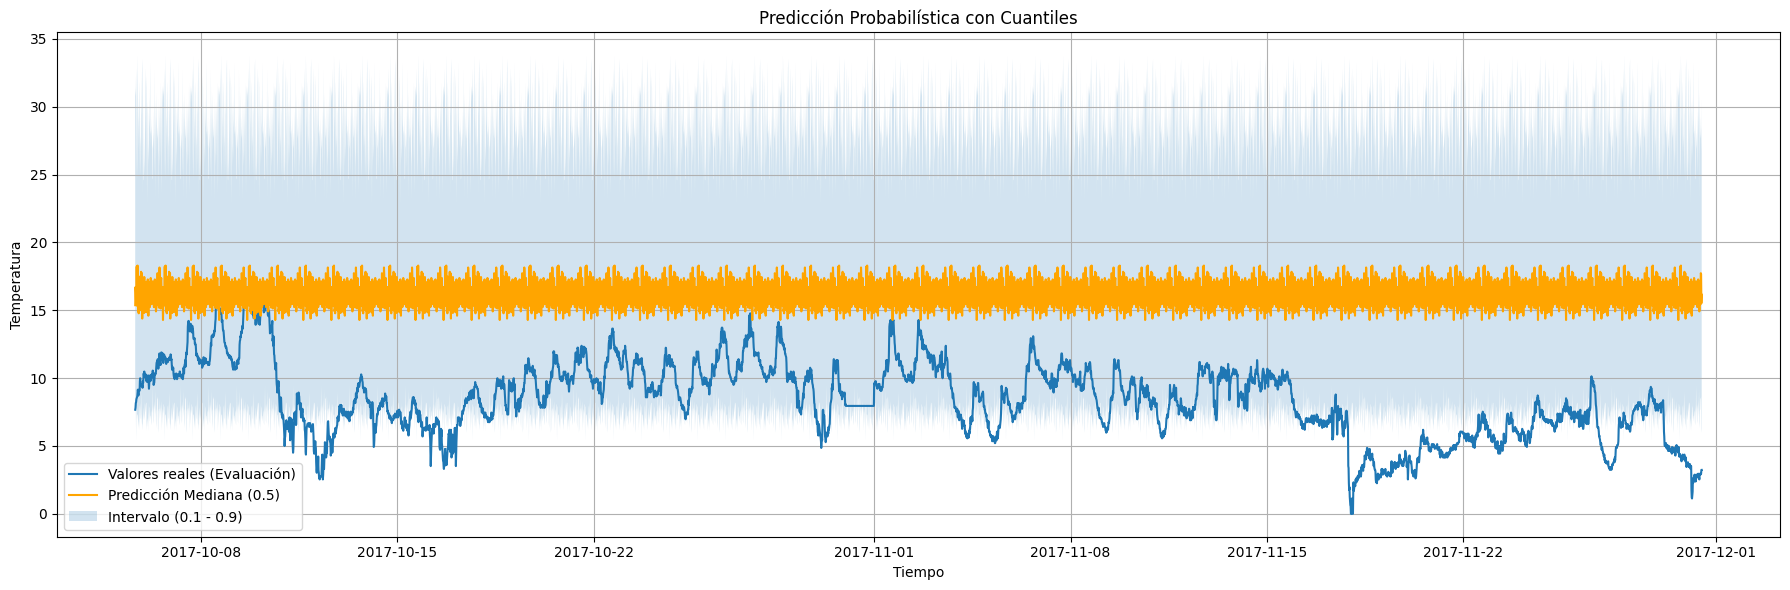

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_and_validate(true_values, pred_df, q_low=0.1, q_high=0.9, q_median=0.5):
    # Asegurar que los índices coincidan
    pred_df.index = true_values.index

    # RMSE para la mediana
    rmse = np.sqrt(mean_squared_error(true_values, pred_df[q_median]))
    print(f"Test RMSE (cuantil {q_median}): {rmse:.3f}")
    
    plt.figure(figsize=(18,6))
    plt.plot(true_values.index, true_values, label='Valores reales (Evaluación)', linewidth=1.5)
    plt.plot(pred_df.index, pred_df[q_median], label=f'Predicción Mediana ({q_median})', color='orange')
    
    plt.fill_between(pred_df.index,
                     pred_df[q_low],
                     pred_df[q_high],
                     alpha=0.2, label=f'Intervalo ({q_low} - {q_high})')
    
    plt.xlabel('Tiempo')
    plt.ylabel('Temperatura')
    plt.title('Predicción Probabilística con Cuantiles')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Asegurar que el índice de predicciones sea datetime
predictions_eval.set_index(pd.to_datetime(predictions_eval["index"]), inplace=True)
predictions_eval.drop(columns=["index"], inplace=True)

# Usar la función
plot_and_validate(eval_data, predictions_eval, q_low=0.1, q_high=0.9, q_median=0.5)


In [246]:
# DATOS DE TEST

#ensemblado mediante bootstrap con un solo modelo simple (NaiveForecaster)

train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])

# 1) Prepara la Serie 'y' con índice datetime y freq ('15T')
y = train_df['Temperature'].copy()
y.index = pd.to_datetime(train_df['date'])
y = y.asfreq('15T')  

fh = ForecastingHorizon(np.arange(1, len(test_df) + 1), is_relative=True)

n_estimators = 100
boot_preds = []

for i in range(n_estimators):
    # a) Generamos índices aleatorios con reemplazo (muestreo bootstrap)
    idx = np.random.RandomState(i).choice(len(y), size=len(y), replace=True)
    
    # b) Muestreamos los valores de 'y' usando los índices aleatorios
    y_boot_values = y.values[idx]
    
    # c) Reconstruimos la serie con el índice original
    y_boot = pd.Series(y_boot_values, index=y.index)
    
    # d) Creamos y entrenamos el Naive Forecaster
    forecaster = NaiveForecaster(strategy="last", sp=96, window_length=96)  # 'sp' = 96 para 24 horas en intervalos de 15 minutos
    forecaster.fit(y_boot)
    
    # e) Realizamos predicciones para el horizonte 'fh'
    preds = forecaster.predict(fh)
    boot_preds.append(preds.values)

# 4) Agregamos los resultados de las predicciones en un array (n_estimators, n_test)
proba_preds = np.vstack(boot_preds)

quantiles = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30,0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65,0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]

quantile_predictions = {"index": test_df.index.values}
for q in quantiles:
    quantile_predictions[q] = np.quantile(proba_preds, q, axis=0)

predictions_test = pd.DataFrame.from_dict(quantile_predictions)

predictions_test


,index,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975
0,64320,2.073250,2.44795,3.0180,4.13950,5.1778,5.99725,7.6611,8.29715,9.3280,...,12.51445,13.5914,15.726250,18.121200,20.453749,21.751400,24.048400,29.095200,33.063000,34.484049
1,64321,-2.532000,-1.09020,3.3060,4.63250,5.2760,6.52450,7.6467,8.46265,9.8064,...,13.84445,15.2654,16.675849,17.249300,18.342751,20.752001,21.941300,22.680100,32.803101,35.062574
2,64322,1.955425,2.38845,4.8466,5.33550,6.2188,7.31600,7.8857,8.65300,10.2710,...,14.07985,15.1530,16.907850,18.838600,21.034000,22.314400,26.481801,33.028100,38.666698,40.356300
3,64323,3.295450,3.72450,4.6779,5.70470,6.6690,7.79100,8.6597,9.77515,10.4536,...,14.10095,14.9984,16.158350,17.178600,18.659500,20.063000,21.698650,25.937200,28.297250,31.958625
4,64324,2.214250,3.14840,4.1500,5.45155,6.4438,7.17550,7.7454,9.51765,10.1300,...,13.84445,15.5750,16.391001,17.115300,18.307751,20.977400,22.370001,25.746701,34.093700,37.600675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,1.503725,2.49335,3.4470,4.59020,5.8950,6.24350,6.9927,7.66800,8.8776,...,11.60700,13.0426,14.941700,17.009600,19.504000,22.061199,23.449950,26.436600,30.917500,34.051500
5356,69676,1.885425,2.79290,3.3907,5.26550,6.4020,7.47425,8.0967,9.32095,10.0036,...,14.87495,15.4060,15.955050,16.834000,18.131751,18.923000,20.886350,24.530201,31.905700,33.415001
5357,69677,1.433200,2.02240,3.7280,4.68135,4.9240,6.27850,7.7667,9.46865,10.6926,...,14.00940,15.3360,16.018000,17.396901,19.891000,22.117200,24.565451,30.720300,32.510550,34.470350
5358,69678,2.706725,3.44700,4.6849,5.25485,6.3316,7.77375,8.9484,10.03515,10.9880,...,13.57000,15.3636,17.027851,18.346600,19.802500,21.596600,22.964650,29.946299,33.206899,37.218449


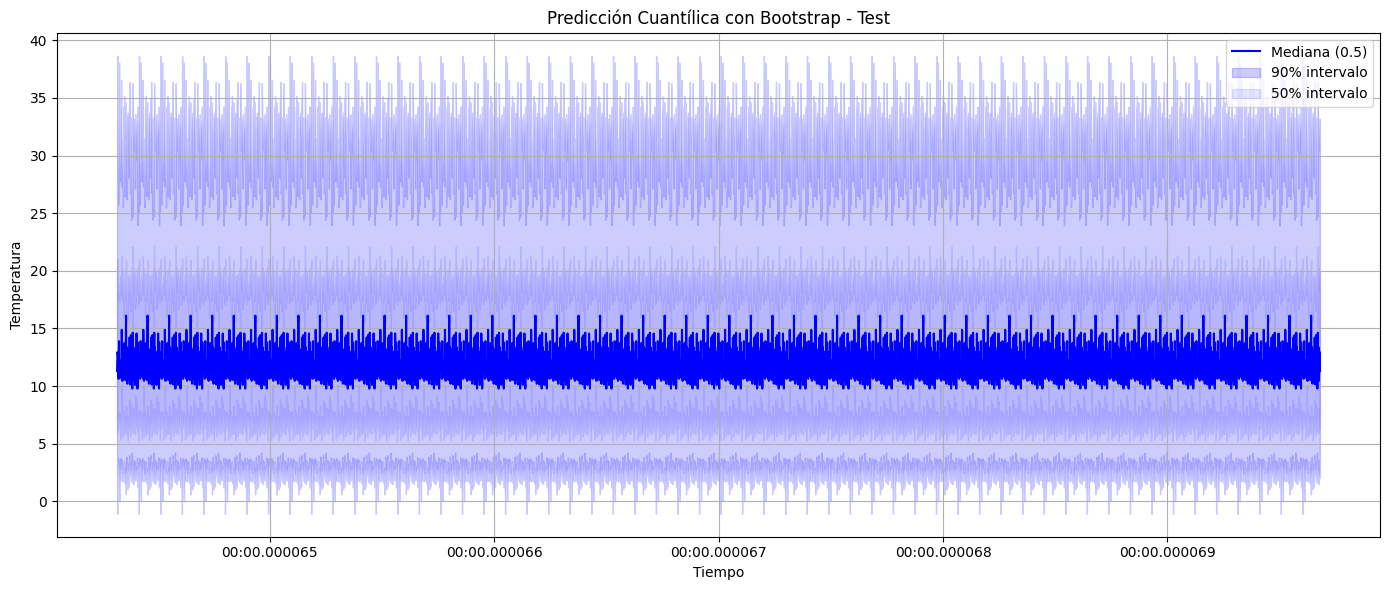

In [247]:
import matplotlib.pyplot as plt
import pandas as pd

predictions_test["index"] = pd.to_datetime(predictions_test["index"])
predictions_test.set_index("index", inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(predictions_test.index, predictions_test[0.50], label="Mediana (0.5)", color="blue")

# Intervalo de confianza 90% (entre 0.05 y 0.95)
plt.fill_between(predictions_test.index,
                 predictions_test[0.05],
                 predictions_test[0.95],
                 color='blue', alpha=0.2, label="90% intervalo")

# Intervalo de confianza 50% (entre 0.25 y 0.75)
plt.fill_between(predictions_test.index,
                 predictions_test[0.25],
                 predictions_test[0.75],
                 color='blue', alpha=0.1, label="50% intervalo")

plt.title("Predicción Cuantílica con Bootstrap - Test")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



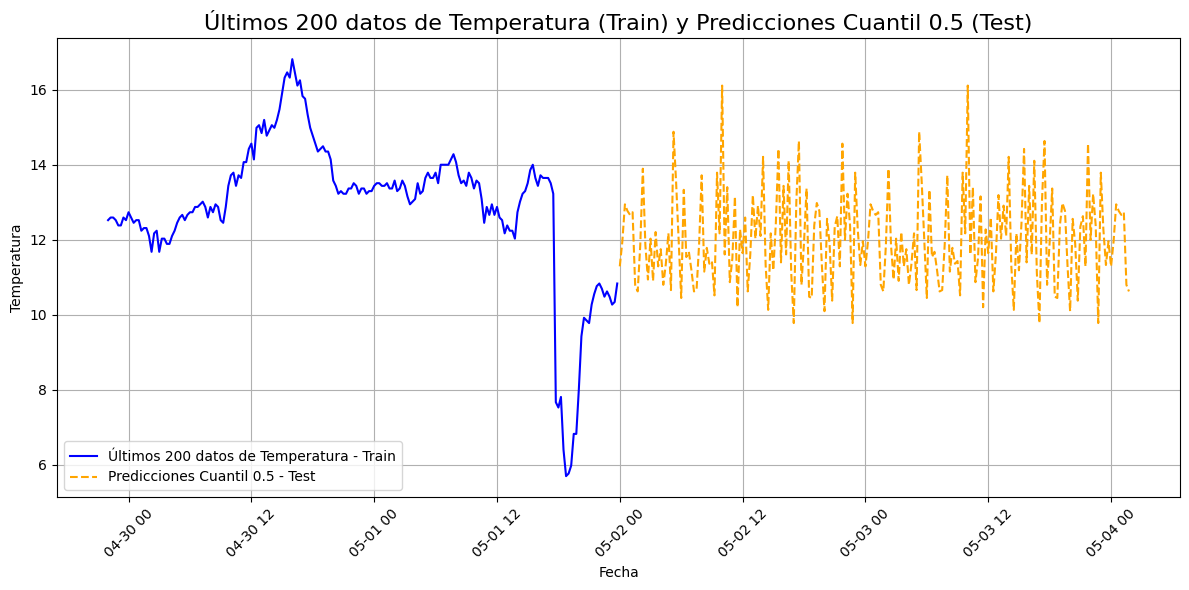

In [248]:
import matplotlib.pyplot as plt
train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)


last_200_train_temp = train_df[['date', 'Temperature']].tail(200)

quantile_50_test = predictions_test[0.50].head(200)
plt.figure(figsize=(12, 6))

# Graficar los últimos 200 valores de la temperatura de train
plt.plot(last_200_train_temp['date'], last_200_train_temp['Temperature'], label='Últimos 200 datos de Temperatura - Train', color='blue')
# Graficar las predicciones cuantil 0.5 de test
plt.plot(test_df['date'].head(200), quantile_50_test, label='Predicciones Cuantil 0.5 - Test', color='orange', linestyle='--')

plt.title('Últimos 200 datos de Temperatura (Train) y Predicciones Cuantil 0.5 (Test)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


## Naive Forecaster sin bootstrap usando método aeon predict_quantiles
tutorial seguido: https://www.aeon-toolkit.org/en/v0.6.0/examples/forecasting/forecasting.html

In [249]:
# DATOS DE EVALUACIÓN

train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])

cutoff = len(train_df) - 20000
train_data = train_df.iloc[:cutoff].copy()
eval_data = train_df.iloc[cutoff:].copy()

train_data.set_index("date", inplace=True)
train_hourly = train_data.resample("15T").mean()

eval_data.set_index("date", inplace=True)
eval_hourly = eval_data.resample("15T").mean()

train_y = train_hourly["Temperature"]
eval_y = eval_hourly["Temperature"]

# Definir horizonte de predicción
fh = ForecastingHorizon(np.arange(1, len(eval_y) + 1), is_relative=True)

# Crear y ajustar modelo
naive_forecaster = NaiveForecaster(strategy="last", sp=14)
naive_forecaster.fit(train_y)

quantiles = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]
quantile_predictions = naive_forecaster.predict_quantiles(fh=fh, alpha=quantiles)

predictions_eval = pd.DataFrame(quantile_predictions)
predictions_eval.columns = [f'Quantile_{q}' for q in quantiles]
predictions_eval["index"] = eval_y.index.values
predictions_eval.set_index("index", inplace=True)

# Calcular RMSE de la mediana (0.5)
rmse = np.sqrt(mean_squared_error(eval_y, predictions_eval["Quantile_0.5"]))
rmse



3.6520561338329345

In [251]:
predictions_eval

,Quantile_0.025,Quantile_0.05,Quantile_0.1,Quantile_0.15,Quantile_0.2,Quantile_0.25,Quantile_0.3,Quantile_0.35,Quantile_0.4,Quantile_0.45,...,Quantile_0.55,Quantile_0.6,Quantile_0.65,Quantile_0.7,Quantile_0.75,Quantile_0.8,Quantile_0.85,Quantile_0.9,Quantile_0.95,Quantile_0.975
index,,,,,,,,,,,,,,,,,,,,,
2017-10-05 16:00:00,2.429451,3.045463,3.755685,4.234868,4.615708,4.942435,5.235846,5.507734,5.765730,6.015344,...,6.506656,6.756270,7.014266,7.286155,7.579565,7.906292,8.287132,8.766315,9.476537,10.092549
2017-10-05 16:15:00,1.444451,2.060463,2.770685,3.249868,3.630708,3.957435,4.250845,4.522734,4.780730,5.030344,...,5.521656,5.771270,6.029266,6.301155,6.594565,6.921292,7.302132,7.781315,8.491537,9.107549
2017-10-05 16:30:00,1.585451,2.201463,2.911685,3.390868,3.771708,4.098435,4.391845,4.663734,4.921730,5.171343,...,5.662656,5.912270,6.170266,6.442154,6.735565,7.062292,7.443131,7.922315,8.632537,9.248549
2017-10-05 16:45:00,1.233451,1.849463,2.559685,3.038868,3.419708,3.746435,4.039845,4.311734,4.569730,4.819344,...,5.310656,5.560270,5.818266,6.090155,6.383565,6.710292,7.091132,7.570315,8.280537,8.896549
2017-10-05 17:00:00,0.600451,1.216463,1.926685,2.405869,2.786708,3.113435,3.406846,3.678734,3.936730,4.186344,...,4.677657,4.927270,5.185266,5.457155,5.750565,6.077292,6.458132,6.937315,7.647537,8.263549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-01 22:45:00,-139.775652,-116.489107,-89.641212,-71.527065,-57.130515,-44.779556,-33.688014,-23.410048,-13.657262,-4.221329,...,14.351330,23.787262,33.540048,43.818014,54.909557,67.260515,81.657065,99.771212,126.619107,149.905653
2018-05-01 23:00:00,-140.408652,-117.122107,-90.274212,-72.160065,-57.763514,-45.412556,-34.321014,-24.043047,-14.290262,-4.854329,...,13.718330,23.154262,32.907048,43.185015,54.276557,66.627515,81.024065,99.138212,125.986107,149.272653
2018-05-01 23:15:00,-140.197652,-116.911107,-90.063212,-71.949065,-57.552514,-45.201556,-34.110014,-23.832047,-14.079262,-4.643329,...,13.929330,23.365262,33.118048,43.396014,54.487557,66.838515,81.235065,99.349212,126.197107,149.483653


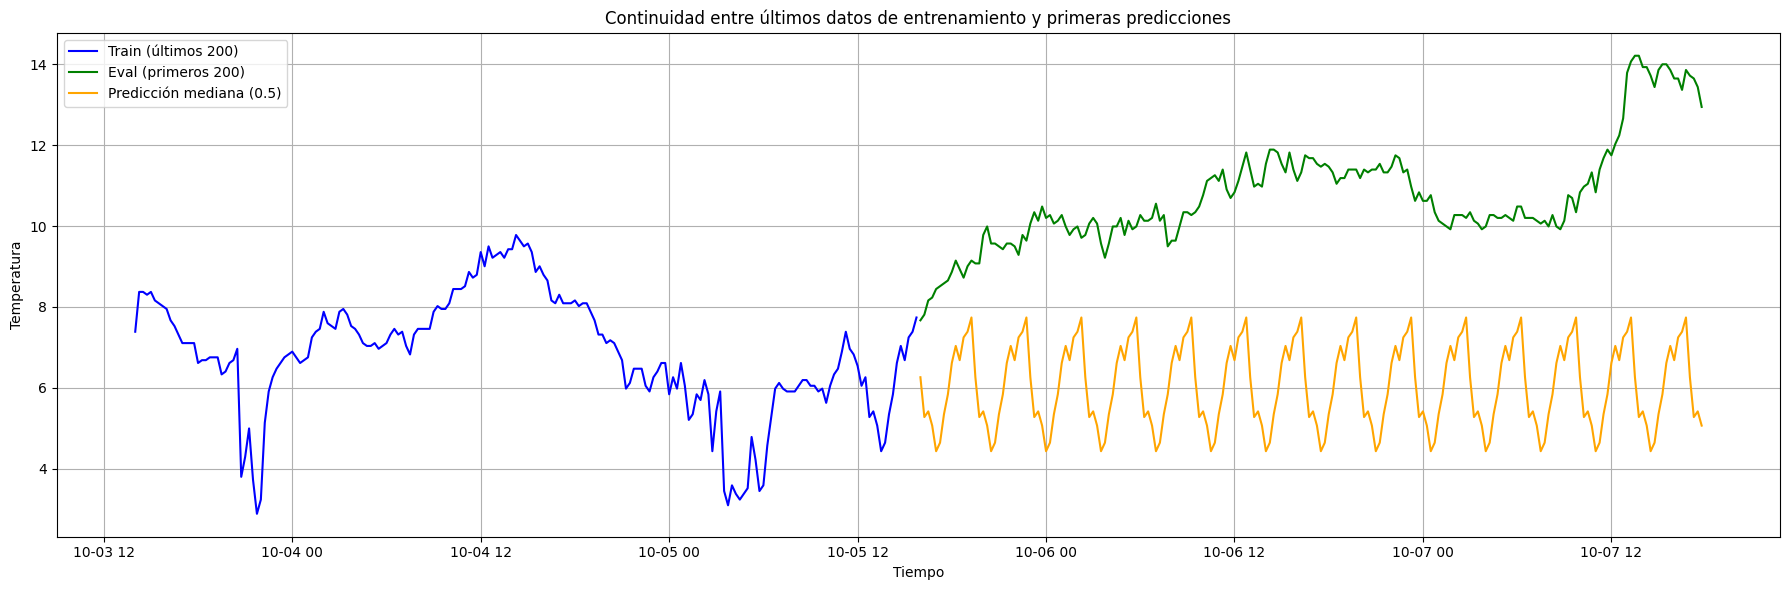

In [255]:
import matplotlib.pyplot as plt

# Extraer los datos para graficar
train_tail = train_y[-200:]
eval_head = eval_y[:200]
pred_head = predictions_eval["Quantile_0.5"][:200]

# Crear figura
plt.figure(figsize=(18,6))
plt.plot(train_tail.index, train_tail, label="Train (últimos 200)", color="blue")
plt.plot(eval_head.index, eval_head, label="Eval (primeros 200)", color="green")
plt.plot(pred_head.index, pred_head, label="Predicción mediana (0.5)", color="orange")

# Etiquetas
plt.xlabel("Tiempo")
plt.ylabel("Temperatura")
plt.title("Continuidad entre últimos datos de entrenamiento y primeras predicciones")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [261]:
# DATOS DE TEST 

from aeon.forecasting.naive import NaiveForecaster
from aeon.forecasting.base import ForecastingHorizon


train_df = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
test_df = pd.read_csv('test.csv', index_col='id', parse_dates=['date'])


train_df.set_index("date", inplace=True)
test_df.set_index("date", inplace=True)

train_df.index.freq = '15T'
test_df.index.freq = '15T'

train_X = train_df[['feature_AA', 'feature_AB', 'feature_BA', 'feature_BB', 'feature_CA', 'feature_CB']]
train_y = train_df['Temperature']

test_X = test_df[['feature_AA', 'feature_AB', 'feature_BA', 'feature_BB', 'feature_CA', 'feature_CB']]

fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)

naive_forecaster = NaiveForecaster(strategy="last", sp=96)  # "last" strategy: predicts the previous value
naive_forecaster.fit(train_y)

quantiles = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 
             0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975]

quantile_predictions = naive_forecaster.predict_quantiles(fh=fh, alpha=quantiles)

quantile_predictions_df = pd.DataFrame(quantile_predictions)

quantile_predictions_df.columns = [f'Quantiles_{q}' for q in quantiles]

quantile_predictions_df["index"] = test_df.index.values[:96]

predictions_test = quantile_predictions_df[["index"] + [col for col in quantile_predictions_df.columns if col != "index"]]
predictions_test


,index,Quantiles_0.025,Quantiles_0.05,Quantiles_0.1,Quantiles_0.15,Quantiles_0.2,Quantiles_0.25,Quantiles_0.3,Quantiles_0.35,Quantiles_0.4,...,Quantiles_0.55,Quantiles_0.6,Quantiles_0.65,Quantiles_0.7,Quantiles_0.75,Quantiles_0.8,Quantiles_0.85,Quantiles_0.9,Quantiles_0.95,Quantiles_0.975
2018-05-02 00:00:00,2018-05-02 00:00:00,7.512132,8.464533,9.562591,10.303445,10.892253,11.397397,11.851032,12.271393,12.670274,...,13.815803,14.201726,14.600607,15.020967,15.474603,15.979747,16.568554,17.309409,18.407466,19.359867
2018-05-02 00:15:00,2018-05-02 00:15:00,7.583132,8.535534,9.633591,10.374445,10.963253,11.468397,11.922032,12.342393,12.741274,...,13.886803,14.272726,14.671607,15.091967,15.545603,16.050747,16.639555,17.380409,18.478466,19.430868
2018-05-02 00:30:00,2018-05-02 00:30:00,7.583132,8.535534,9.633591,10.374445,10.963253,11.468397,11.922032,12.342393,12.741274,...,13.886803,14.272726,14.671607,15.091967,15.545603,16.050747,16.639555,17.380409,18.478466,19.430868
2018-05-02 00:45:00,2018-05-02 00:45:00,7.512132,8.464533,9.562591,10.303445,10.892253,11.397397,11.851032,12.271393,12.670274,...,13.815803,14.201726,14.600607,15.020967,15.474603,15.979747,16.568554,17.309409,18.407466,19.359867
2018-05-02 01:00:00,2018-05-02 01:00:00,7.512132,8.464533,9.562591,10.303445,10.892253,11.397397,11.851032,12.271393,12.670274,...,13.815803,14.201726,14.600607,15.020967,15.474603,15.979747,16.568554,17.309409,18.407466,19.359867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-02 22:45:00,2018-05-02 22:45:00,4.698132,5.650533,6.748591,7.489445,8.078253,8.583397,9.037032,9.457393,9.856274,...,11.001803,11.387725,11.786607,12.206967,12.660602,13.165747,13.754554,14.495409,15.593466,16.545867
2018-05-02 23:00:00,2018-05-02 23:00:00,4.558133,5.510534,6.608592,7.349446,7.938253,8.443398,8.897033,9.317394,9.716275,...,10.861804,11.247726,11.646607,12.066968,12.520603,13.025747,13.614555,14.355409,15.453467,16.405868
2018-05-02 23:15:00,2018-05-02 23:15:00,4.347132,5.299534,6.397591,7.138445,7.727253,8.232397,8.686032,9.106393,9.505274,...,10.650803,11.036726,11.435607,11.855967,12.309603,12.814747,13.403554,14.144409,15.242466,16.194867
2018-05-02 23:30:00,2018-05-02 23:30:00,4.417132,5.369533,6.467591,7.208445,7.797252,8.302397,8.756032,9.176393,9.575274,...,10.720803,11.106725,11.505606,11.925967,12.379602,12.884747,13.473554,14.214408,15.312466,16.264867


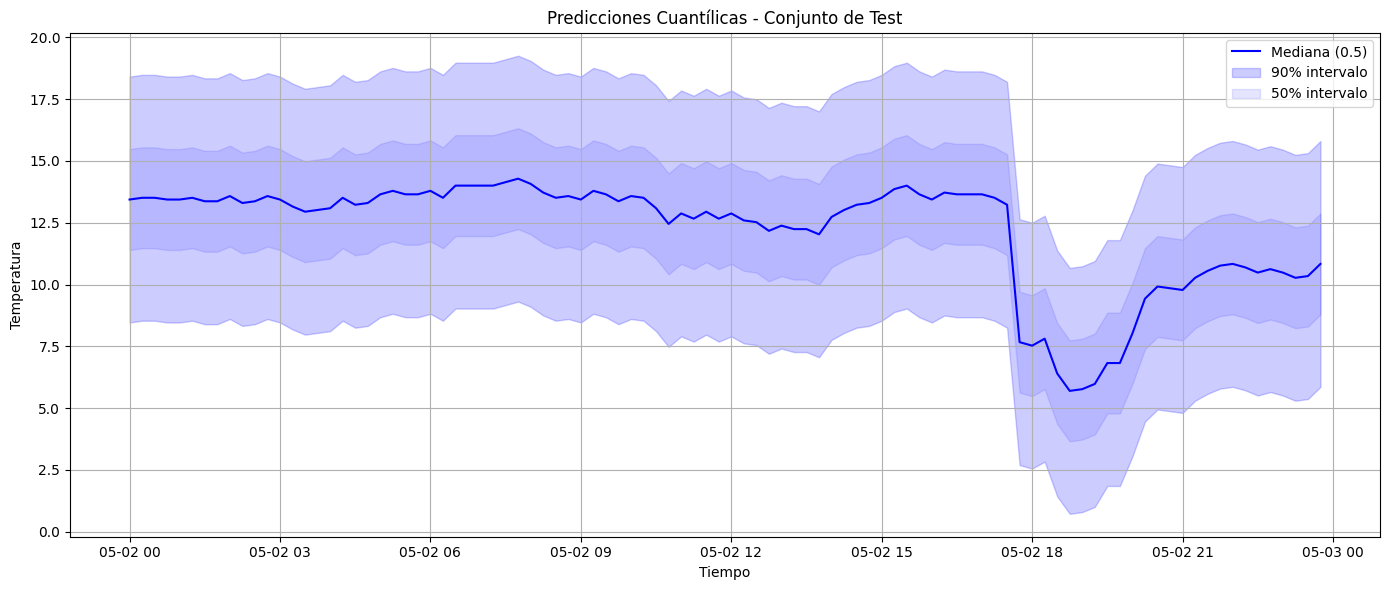

In [262]:
import matplotlib.pyplot as plt
import pandas as pd

predictions_test["index"] = pd.to_datetime(predictions_test["index"])
predictions_test.set_index("index", inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(predictions_test.index, predictions_test["Quantiles_0.5"], label="Mediana (0.5)", color="blue")

# Intervalo de confianza 90% (entre 0.05 y 0.95)
plt.fill_between(predictions_test.index,
                 predictions_test["Quantiles_0.05"],
                 predictions_test["Quantiles_0.95"],
                 color='blue', alpha=0.2, label="90% intervalo")

# Intervalo de confianza 50% (entre 0.25 y 0.75)
plt.fill_between(predictions_test.index,
                 predictions_test["Quantiles_0.25"],
                 predictions_test["Quantiles_0.75"],
                 color='blue', alpha=0.1, label="50% intervalo")

plt.title("Predicciones Cuantílicas - Conjunto de Test")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


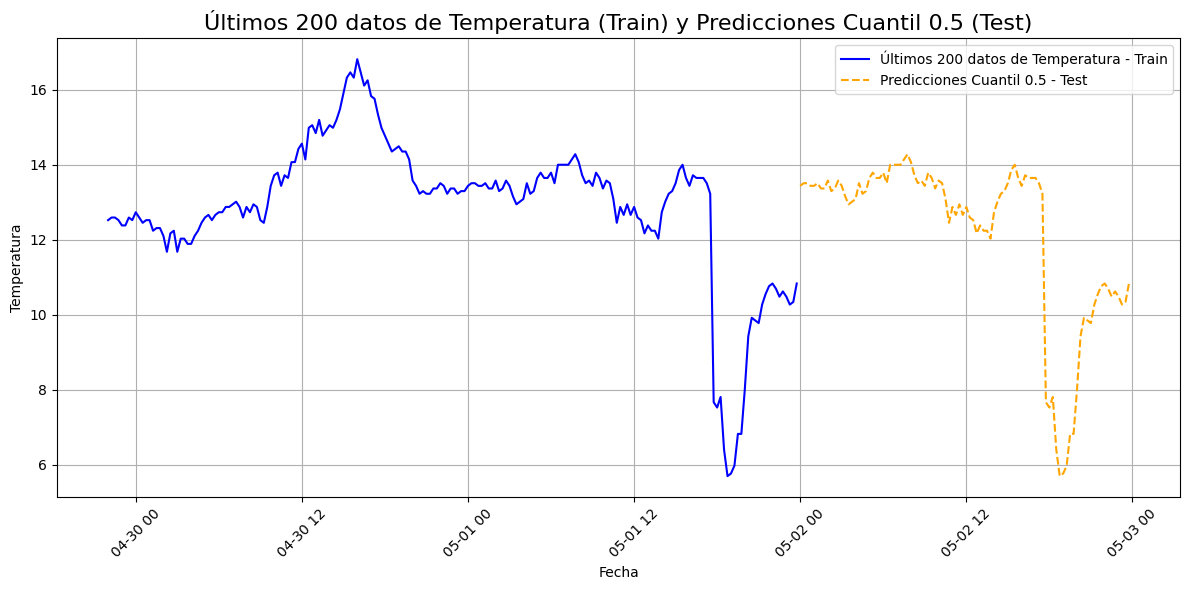

In [270]:
import matplotlib.pyplot as plt

last_200_train_temp = train_df[['Temperature']].tail(200)
quantile_50_test = predictions_test['Quantiles_0.5'].head(200)
predictions_test.reset_index(inplace=True)

# Graficar los últimos 200 puntos de train_df junto con los primeros 200 puntos de test_df
plt.figure(figsize=(12, 6))
# Graficar los últimos 200 valores de temperatura de train_df
plt.plot(last_200_train_temp.index, last_200_train_temp['Temperature'], label='Últimos 200 datos de Temperatura - Train', color='blue')

plt.plot(predictions_test['index'].head(200), quantile_50_test, label='Predicciones Cuantil 0.5 - Test', color='orange', linestyle='--')

# Título y etiquetas
plt.title('Últimos 200 datos de Temperatura (Train) y Predicciones Cuantil 0.5 (Test)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
